    # Test signal generation and processing functions
In this file you can see how generate and process WDM signal

In [1]:
import sys
sys.path[0:]

['/home/esf0/PycharmProjects/nft_processing/notebooks',
 '/home/esf0/PycharmProjects/nft_processing',
 '/home/esf0/anaconda3/envs/nn_env/lib/python39.zip',
 '/home/esf0/anaconda3/envs/nn_env/lib/python3.9',
 '/home/esf0/anaconda3/envs/nn_env/lib/python3.9/lib-dynload',
 '',
 '/home/esf0/anaconda3/envs/nn_env/lib/python3.9/site-packages',
 '/home/esf0/anaconda3/envs/nn_env/lib/python3.9/site-packages/scikit_commpy-0.7.0-py3.9.egg',
 '/home/esf0/anaconda3/envs/nn_env/lib/python3.9/site-packages/sympy-1.10.1-py3.9.egg',
 '/home/esf0/anaconda3/envs/nn_env/lib/python3.9/site-packages/mpmath-1.2.1-py3.9.egg']

In [2]:
sys.path.append('/home/esf0/PycharmProjects/nft_processing/')
sys.path.append('/home/esf0/PycharmProjects/nft_processing/signal_handling')
sys.path.append('/home/esf0/PycharmProjects/nft_processing/nft_handling')

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from importlib import reload

from prettytable import PrettyTable


from scipy.fft import fftshift, ifftshift, fft, ifft

import hpcom
from hpcom.signal import create_wdm_parameters, generate_wdm, get_points_wdm, receiver_wdm, nonlinear_shift, rrcosfilter
from hpcom.channel import create_channel_parameters

from ssfm_gpu.propagation import propagate_manakov, dispersion_compensation_manakov

# from signal_handling.processing import get_process_parameters, get_default_process_parameters, get_windowed_signal
import signal_handling.processing as prcs

reload(prcs)
reload(hpcom)

from hpcom.signal import create_wdm_parameters, generate_wdm, get_points_wdm, receiver_wdm, nonlinear_shift, rrcosfilter

2023-05-03 15:17:16.322633: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


It is better to allocate memory for GPU before using it

It can take a while for some systems to allocate memory.
But if you will not close jupyter server next runs of gpu-related functions will be fast.
Usually I see such problem for linux systems

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

### Generation of signal and channel

In [ ]:
wdm = create_wdm_parameters(n_channels=1, p_ave_dbm=0, n_symbols=2 ** 14, m_order=16, roll_off=0.1, upsampling=16,
                            downsampling_rate=1, symb_freq=34e9, channel_spacing=75e9, n_polarisations=2, seed='fixed')

channel = create_channel_parameters(n_spans=1,
                                    z_span=80,
                                    alpha_db=0.0,
                                    gamma=1.2,
                                    noise_figure_db=-200,  # -200 means there is no noise
                                    dispersion_parameter=16.8,
                                    dz=1)

In [ ]:
signal_x, signal_y, wdm_info = generate_wdm(wdm)
signal_original = (signal_x, signal_y)
signal = (signal_x, signal_y)

points_x_orig = wdm_info['points_x'][0]  # [0] index for only one WDM channel
points_y_orig = wdm_info['points_y'][0]
ft_filter_values = wdm_info['ft_filter_values_x']
points_x_wo_prop = get_points_wdm(receiver_wdm(signal[0], ft_filter_values, wdm)[0], wdm)
points_y_wo_prop = get_points_wdm(receiver_wdm(signal[1], ft_filter_values, wdm)[0], wdm)


filter_length = 2 ** 10
symb_freq = int(wdm['symb_freq'])  # symbol frequency
sample_freq = int(symb_freq * wdm['upsampling'])  # sampling frequency used for the discrete simulation of analog signals
t_s = 1 / symb_freq  # symbol spacing
filter_values = rrcosfilter(filter_length, wdm['roll_off'], t_s, sample_freq)

points_x_wo_prop_slow = np.convolve(signal_x, filter_values)
conv_shift = int(filter_length / 2)
points_x_wo_prop_slow = points_x_wo_prop_slow[conv_shift:-conv_shift]
points_x_wo_prop_slow = points_x_wo_prop_slow[::wdm['upsampling']]

add_temp = 0
# points_x_wo_prop_slow_new = points_x_wo_prop_slow[conv_shift + add_temp:conv_shift + wdm['n_symbols'] - add_temp]

# calculate propagation
start_time = datetime.now()
signal = propagate_manakov(channel, signal[0], signal[1], wdm['sample_freq'])
print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

if wdm['n_polarisations'] == 2:
    signal = (signal[0].numpy(), signal[1].numpy())
else:
    signal = signal.numpy()

In [26]:
print(np.max(points_x_wo_prop * scale - points_x_orig))
print(scale, points_x_wo_prop[:10] * scale, points_x_orig[:10])
print(np.sqrt(np.sum(np.power(np.absolute(ft_filter_values), 2))))
print(2**14, len(points_x_wo_prop)-len(points_x_wo_prop_slow), (len(points_x_wo_prop)-len(points_x_wo_prop_slow)) * wdm['upsampling'])

(1.1539832492357682e-09-5.1764656797126385e-11j)
(16831.6761229066-3.4285196654721454e-12j) [ 0.00707107-0.00707107j -0.0212132 +0.00707107j  0.0212132 +0.0212132j
  0.00707107+0.00707107j  0.0212132 -0.0212132j   0.00707107+0.0212132j
 -0.00707107-0.00707107j  0.0212132 +0.00707107j  0.00707107-0.00707107j
  0.00707107-0.0212132j ] [ 0.00707107-0.00707107j -0.0212132 +0.00707107j  0.0212132 +0.0212132j
  0.00707107+0.00707107j  0.0212132 -0.0212132j   0.00707107+0.0212132j
 -0.00707107-0.00707107j  0.0212132 +0.00707107j  0.00707107-0.00707107j
  0.00707107-0.0212132j ]
2047.999999999607
16384 0 0


In [126]:
table = PrettyTable()
n_rows = 15
n_rows_shift = 64
for k in range(n_rows):
    table.add_row(['{:.5f}'.format(points_x_orig[n_rows_shift + k]),
                   '{:.5f}'.format(points_x_wo_prop[n_rows_shift + k] * scale),
                   '{:.5f}'.format(points_x_wo_prop_slow[n_rows_shift + k])])

print(table)

+-------------------+-------------------+-------------------+
|      Field 1      |      Field 2      |      Field 3      |
+-------------------+-------------------+-------------------+
|  0.02121-0.00707j |  0.02121-0.00707j | -0.11309-0.11322j |
| -0.02121+0.02121j | -0.02121+0.02121j | -0.11308-0.11303j |
| -0.02121-0.00707j | -0.02121-0.00707j |  0.33936-0.33938j |
|  0.02121-0.02121j |  0.02121-0.02121j | -0.11308+0.33945j |
|  0.02121-0.02121j |  0.02121-0.02121j |  0.33934-0.33942j |
| -0.00707+0.00707j | -0.00707+0.00707j | -0.11302-0.33937j |
| -0.02121-0.02121j | -0.02121-0.02121j |  0.11300+0.11309j |
|  0.02121-0.00707j |  0.02121-0.00707j |  0.33962+0.33937j |
| -0.02121+0.00707j | -0.02121+0.00707j | -0.11341+0.33937j |
|  0.02121-0.02121j |  0.02121-0.02121j | -0.33916-0.33939j |
|  0.00707+0.02121j |  0.00707+0.02121j | -0.11335+0.33939j |
|  0.02121+0.02121j |  0.02121+0.02121j |  0.33962+0.11309j |
|  0.00707-0.00707j |  0.00707-0.00707j | -0.11336-0.11293j |
| -0.021

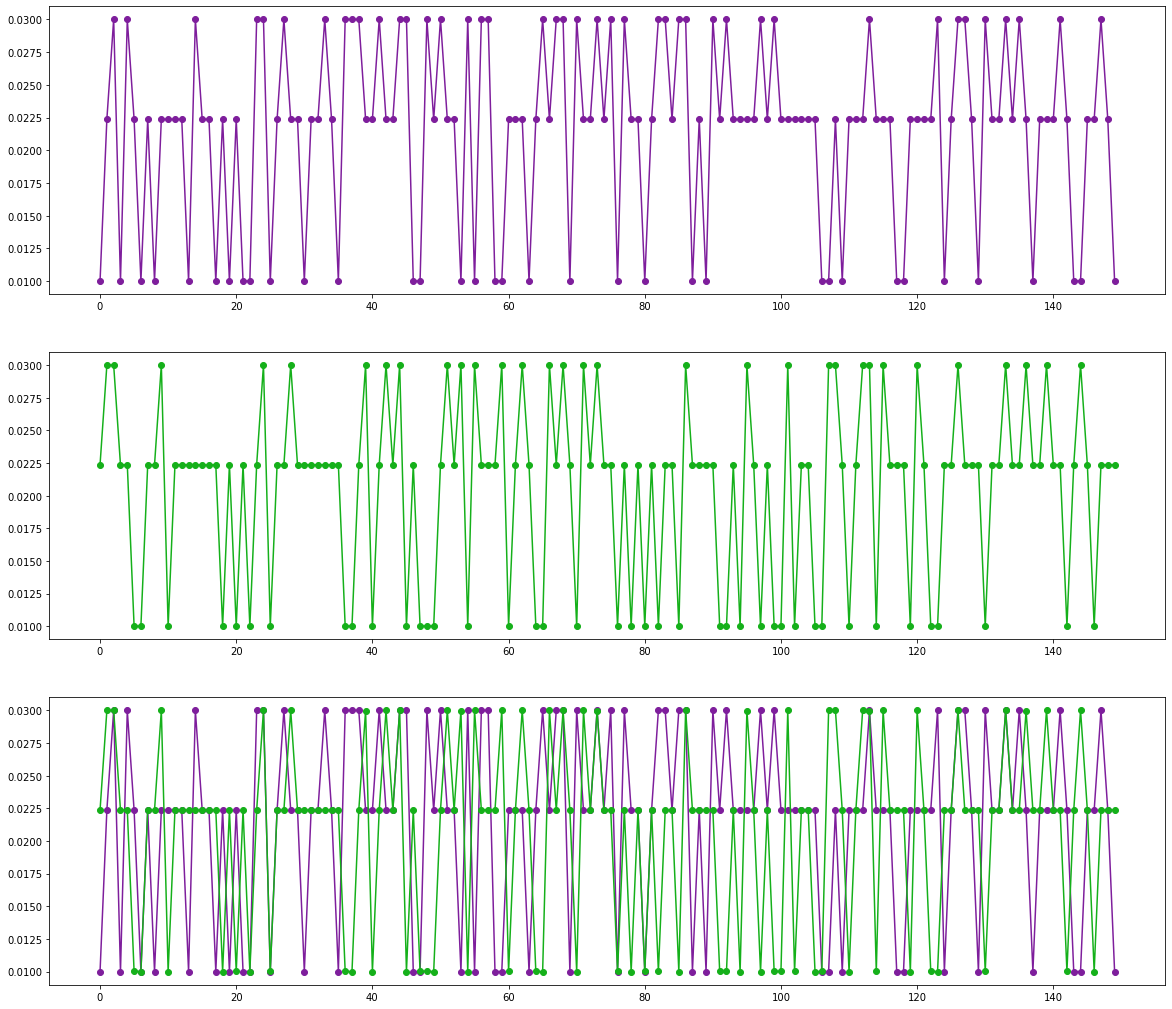

In [25]:
fig, axs = plt.subplots(3, 1, figsize=(20, 18))

plt_sh = 0
n_plt = 100
axs[0].plot(np.absolute(points_x_orig[-n_plt:]), color='xkcd:purple', marker='o')
axs[1].plot(np.absolute(fftshift(points_x_wo_prop_slow)[-n_plt:] * 0.062), color='xkcd:green', marker='o')
axs[2].plot(np.absolute(points_x_orig[-n_plt:]), color='xkcd:purple', marker='o')
axs[2].plot(np.absolute(fftshift(points_x_wo_prop_slow)[-n_plt:] * 0.062), color='xkcd:green', marker='o')

# axs[0].plot(np.absolute(points_x_orig[:n_plt]), color='xkcd:purple', marker='o')
# axs[1].plot(np.absolute(fftshift(points_x_wo_prop_slow)[:n_plt] * 0.062), color='xkcd:green', marker='o')
# axs[2].plot(np.absolute(points_x_orig[:n_plt]), color='xkcd:purple', marker='o')
# axs[2].plot(np.absolute(fftshift(points_x_wo_prop_slow)[:n_plt] * 0.062), color='xkcd:green', marker='o')

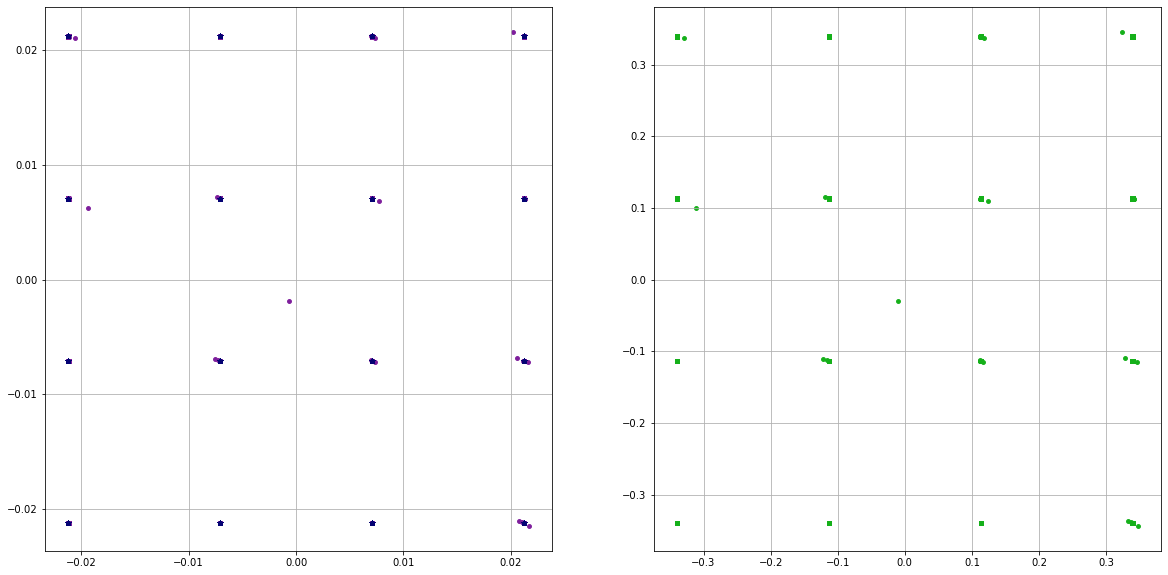

In [21]:
# scale = np.sum(np.power(np.absolute(ft_filter_values), 2))
scale = np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_orig) / np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_wo_prop)
scale_new = np.dot(np.transpose(np.conjugate(points_x_orig[add_temp:-add_temp])), points_x_orig[add_temp:-add_temp]) / np.dot(np.transpose(np.conjugate(points_x_orig[add_temp:-add_temp])), points_x_wo_prop_slow_new)


fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# axs[0].scatter(points_x_wo_prop.real * scale, points_x_wo_prop.imag * scale, s=15, c='xkcd:purple', marker='o')
axs[0].scatter(points_x_wo_prop_slow.real * scale_new, points_x_wo_prop_slow.imag * scale_new, s=15, c='xkcd:purple', marker='o')
# axs[0].scatter(points_x_cdc.real, points_x_cdc.imag, s=30, c='xkcd:green', marker='.')
# axs[0].scatter(points_x_cdc_shifted.real, points_x_cdc_shifted.imag, s=30, c='green', marker='x')
axs[0].scatter(points_x_orig.real, points_x_orig.imag, s=20, c='xkcd:deep blue', marker='*')
# axs[0].scatter(points_x_cdc_test[n_start_test:n_end_test].real, points_x_cdc_test[n_start_test:n_end_test].imag, s=20, c='xkcd:purple', marker='o')
axs[0].grid(True)

axs[1].scatter(points_x_wo_prop_slow_new.real, points_x_wo_prop_slow_new.imag, s=15, c='xkcd:green', marker='o')
# axs[1].scatter(points_y_wo_prop.real * scale, points_y_wo_prop.imag * scale, s=6, c='xkcd:green', marker='.')
# # axs[1].scatter(points_y_cdc_shifted.real, points_y_cdc_shifted.imag, s=6, c='xkcd:green', marker='x')
# axs[1].scatter(points_y_orig.real, points_y_orig.imag, s=20, c='xkcd:deep blue', marker='*')
axs[1].grid(True)

In [16]:
# get processing parameters
process_parameters = prcs.get_default_process_parameters()
process_parameters['window_mode'] = 'plain'
process_parameters['n_symb_proc'] = 2 ** 4
process_parameters['n_symb_side'] = 32
process_parameters['n_symb_total'] = process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side']
process_parameters['n_symb_skip'] = 512


for key, value in process_parameters.items():
    print(key, value)

z_prop 0
n_symb_proc 16
n_symb_side 32
n_symb_total 80
n_symb_skip 512
n_symb_add 0
window_mode plain
xi_upsampling 1
forward_continuous_type fnft
forward_discrete_type fnft
forward_discrete_coef_type fnftpoly
inverse_type both
fnft_type 0
nft_type bo
use_contour False
n_discrete_skip 10
print_sys_message False
n_steps 1


In [17]:
process_parameters['window_mode'] = 'plain'
process_parameters['n_symb_add'] = 0
signal_windowed, t_window = prcs.get_windowed_signal(signal, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)

process_parameters['window_mode'] = 'cdc'
process_parameters['n_symb_add'] = 16
signal_windowed_cdc, t_window_cdc = prcs.get_windowed_signal(signal, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)

# for key, value in process_parameters.items():
#     print(key, value)

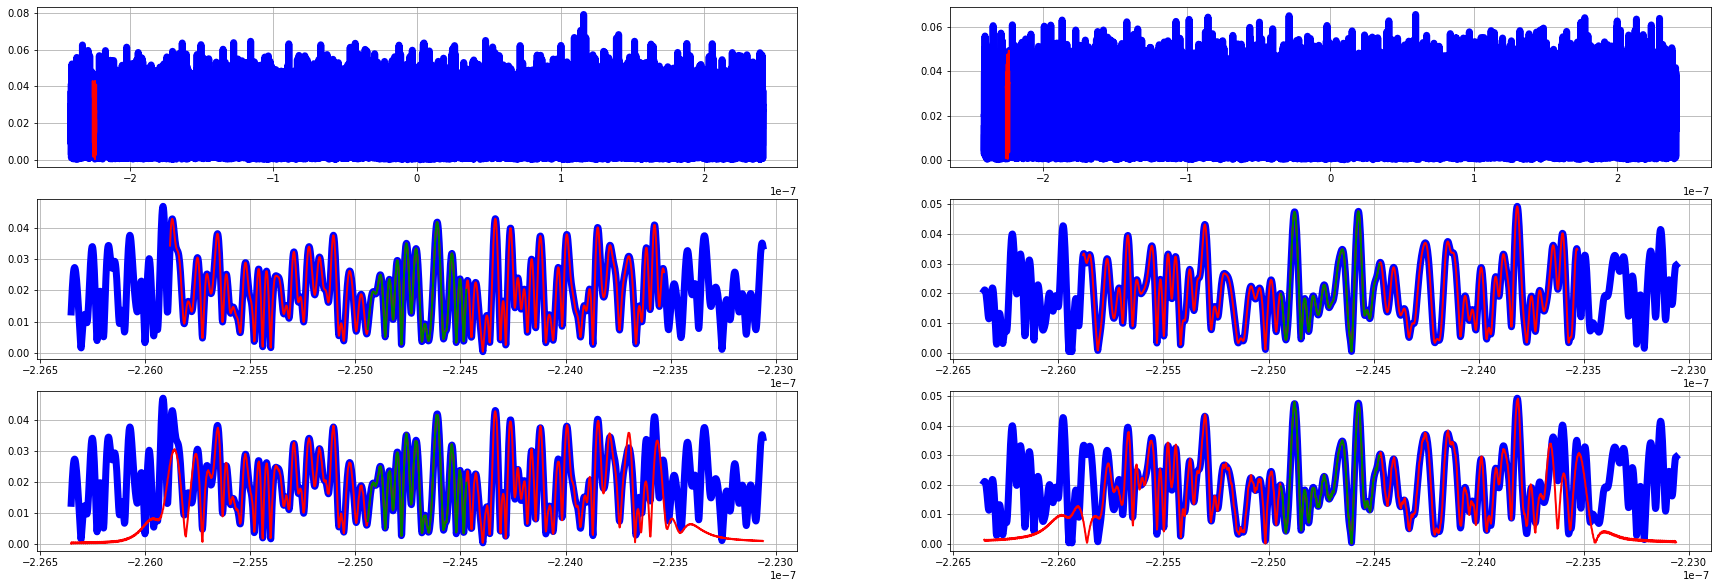

In [18]:
t = (np.arange(len(signal[0])) - len(signal[0]) / 2) / wdm['sample_freq']
plot_shift = 0
range_start = int((process_parameters['n_symb_skip'] - process_parameters['n_symb_add'] - plot_shift) * wdm['upsampling'])
range_end = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_total'] + process_parameters['n_symb_add'] + plot_shift) * wdm['upsampling'])
plot_range = range(range_start, range_end)

range_proc_start = int((process_parameters['n_symb_side'] ) * wdm['upsampling'])
range_proc_end = int((process_parameters['n_symb_side'] + process_parameters['n_symb_proc']) * wdm['upsampling'])
plot_range_proc = range(range_proc_start, range_proc_end)

range_proc_window_start = int((process_parameters['n_symb_side'] + process_parameters['n_symb_add']) * wdm['upsampling'])
range_proc_window_end = int((process_parameters['n_symb_side'] + process_parameters['n_symb_proc'] + process_parameters['n_symb_add']) * wdm['upsampling'])
plot_range_proc_window = range(range_proc_window_start, range_proc_window_end)

fig, axs = plt.subplots(3, 2, figsize=(30, 10))

for k in [0, 1]:
    axs[0][k].plot(t, np.absolute(signal[k]), linewidth=7, color='blue')
    axs[0][k].plot(t_window, np.absolute(signal_windowed[k]), linewidth=2, color='red')
    axs[0][k].grid(True)

    axs[1][k].plot(t[plot_range], np.absolute(signal[k][plot_range]), linewidth=7, color='blue')
    # processing interval with side intervals
    axs[1][k].plot(t_window, np.absolute(signal_windowed[k]), linewidth=2, color='red')
    # processing interval
    axs[1][k].plot(t_window[plot_range_proc], np.absolute(signal_windowed[k][plot_range_proc]), linewidth=2, color='green')
    axs[1][k].grid(True)

    axs[2][k].plot(t[plot_range], np.absolute(signal[k][plot_range]), linewidth=7, color='blue')
    # processing interval with side and additional intervals
    axs[2][k].plot(t_window_cdc, np.absolute(signal_windowed_cdc[k]), linewidth=2, color='red')
    # processing interval
    axs[2][k].plot(t_window_cdc[plot_range_proc_window], np.absolute(signal_windowed_cdc[k][plot_range_proc_window]), linewidth=2, color='green')
    axs[2][k].grid(True)

In [19]:
points_x_orig = wdm_info['points_x'][0]  # [0] index for only one WDM channel
points_y_orig = wdm_info['points_y'][0]
ft_filter_values = wdm_info['ft_filter_values_x']


# Manakov case
signal_cdc = dispersion_compensation_manakov(channel, signal[0], signal[1], 1. / wdm['sample_freq'])

if wdm['n_polarisations'] == 2:
    signal_cdc = (signal_cdc[0].numpy(), signal_cdc[1].numpy())
else:
    signal_cdc = signal_cdc.numpy()

points_x_cdc = get_points_wdm(receiver_wdm(signal_cdc[0], ft_filter_values, wdm)[0], wdm)  # [0] index for only one WDM channel
points_y_cdc = get_points_wdm(receiver_wdm(signal_cdc[1], ft_filter_values, wdm)[0], wdm)

shift_factor_x = np.absolute(nonlinear_shift(points_x_cdc, points_x_orig))
shift_factor_y = np.absolute(nonlinear_shift(points_y_cdc, points_y_orig))

# shift_factor_x = nonlinear_shift(points_x_cdc, points_x_orig)
# shift_factor_y = nonlinear_shift(points_y_cdc, points_y_orig)

points_x_cdc_shifted = points_x_cdc * shift_factor_x
points_y_cdc_shifted = points_y_cdc * shift_factor_y


Matched filter took 71.733 ms
Matched filter took 64.499 ms


In [21]:
n_total_test = len(signal_cdc[0])
n_start_test = 100
n_end_test = 500
range_test = range(n_start_test * wdm['upsampling'], n_end_test * wdm['upsampling'])
signal_cut_test = np.zeros(n_total_test, dtype=complex)
signal_cut_test[range_test] = signal_cdc[0][range_test]
range_center = range(n_total_test // 2 - (n_end_test - n_start_test) * wdm['upsampling'] // 2, n_total_test // 2 + (n_end_test - n_start_test) * wdm['upsampling'] // 2)
# signal_cut_test[range_center] = signal_cdc[0][range_test]

range_left_test = range(0, n_start_test * wdm['upsampling'])
range_right_test = range(n_end_test * wdm['upsampling'], n_total_test)
signal_rest_test = np.zeros(n_total_test, dtype=complex)
signal_rest_test[range_left_test] = signal_cdc[0][range_left_test]
signal_rest_test[range_right_test] = signal_cdc[0][range_right_test]

points_x_cdc_test = get_points_wdm(receiver_wdm(signal_cut_test, ft_filter_values, wdm)[0], wdm)  # [0] index for only one WDM channel
points_x_cdc_test *= shift_factor_x

Matched filter took 64.59700000000001 ms


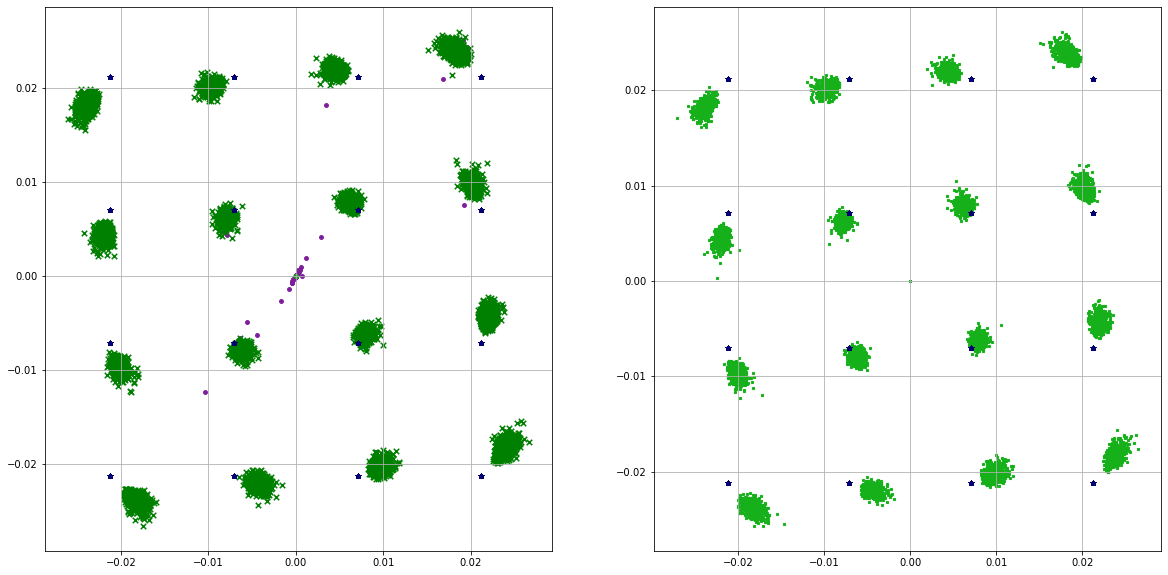

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(points_x_cdc_test.real, points_x_cdc_test.imag, s=15, c='xkcd:purple', marker='o')

axs[0].scatter(points_x_cdc.real, points_x_cdc.imag, s=30, c='xkcd:green', marker='.')
axs[0].scatter(points_x_cdc_shifted.real, points_x_cdc_shifted.imag, s=30, c='green', marker='x')
axs[0].scatter(points_x_orig.real, points_x_orig.imag, s=20, c='xkcd:deep blue', marker='*')
# axs[0].scatter(points_x_cdc_test[n_start_test:n_end_test].real, points_x_cdc_test[n_start_test:n_end_test].imag, s=20, c='xkcd:purple', marker='o')
axs[0].grid(True)

axs[1].scatter(points_y_cdc.real, points_y_cdc.imag, s=6, c='xkcd:green', marker='.')
axs[1].scatter(points_y_cdc_shifted.real, points_y_cdc_shifted.imag, s=6, c='xkcd:green', marker='x')
axs[1].scatter(points_y_orig.real, points_y_orig.imag, s=20, c='xkcd:deep blue', marker='*')
axs[1].grid(True)

In [146]:
diff_x = np.absolute(points_x_cdc_shifted - points_x_orig)
print(np.mean(diff_x), np.max(diff_x))
print(points_x_orig)
print(points_x_cdc_shifted)

0.002576733357458323 0.00732902718759783
[ 0.00707107-0.00707107j -0.0212132 +0.00707107j  0.0212132 +0.0212132j
 ... -0.0212132 +0.0212132j   0.0212132 -0.00707107j
  0.0212132 -0.0212132j ]
[ 0.00760887-0.00600903j -0.02202902+0.00477801j  0.01907475+0.02315904j
 ... -0.02286778+0.01893548j  0.0222853 -0.00501733j
  0.02310426-0.01901282j]


In [159]:
process_parameters['window_mode'] = 'test'
process_parameters['n_symb_add'] = 0
result_nft = prcs.process_nft_window(signal, wdm, process_parameters, channel=channel)
signal_nft = result_nft['signal_restored']
print(np.shape(signal_nft), np.shape(signal_nft[0]), type(signal_nft[0]))

if wdm['n_polarisations'] == 2:
    signal_nft = (signal_nft[0].numpy(), signal_nft[1].numpy())
else:
    signal_nft = signal_nft.numpy()

print(np.shape(signal_nft), np.shape(signal_nft[0]), type(signal_nft[0]))


(2, 2048) 384
(2, 1280)
(2, 1280) (1280,) <class 'tensorflow.python.framework.ops.EagerTensor'>
(2, 1280) (1280,) <class 'numpy.ndarray'>


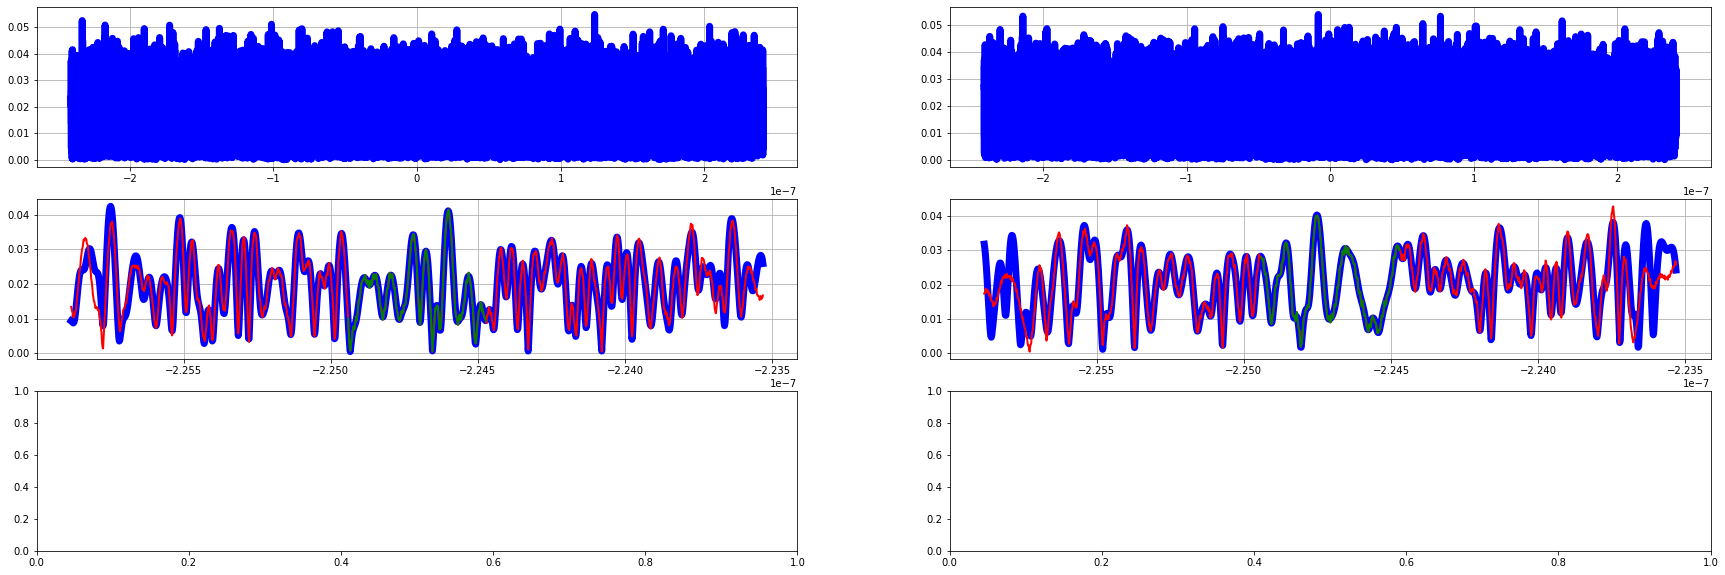

In [160]:
t = (np.arange(len(signal[0])) - len(signal[0]) / 2) / wdm['sample_freq']
plot_shift = 0
range_start = int((process_parameters['n_symb_skip'] - process_parameters['n_symb_add'] - plot_shift) * wdm['upsampling'])
range_end = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_total'] + process_parameters['n_symb_add'] + plot_shift) * wdm['upsampling'])
plot_range = range(range_start, range_end)

range_proc_start = int((process_parameters['n_symb_side'] ) * wdm['upsampling'])
range_proc_end = int((process_parameters['n_symb_side'] + process_parameters['n_symb_proc']) * wdm['upsampling'])
plot_range_proc = range(range_proc_start, range_proc_end)

range_proc_window_start = int((process_parameters['n_symb_side'] + process_parameters['n_symb_add']) * wdm['upsampling'])
range_proc_window_end = int((process_parameters['n_symb_side'] + process_parameters['n_symb_proc'] + process_parameters['n_symb_add']) * wdm['upsampling'])
plot_range_proc_window = range(range_proc_window_start, range_proc_window_end)

fig, axs = plt.subplots(3, 2, figsize=(30, 10))

for k in [0, 1]:
    axs[0][k].plot(t, np.absolute(signal_cdc[k]), linewidth=7, color='blue')
    # axs[0][k].plot(t_window, np.absolute(signal_windowed[k]), linewidth=2, color='red')
    axs[0][k].grid(True)

    axs[1][k].plot(t[plot_range], np.absolute(signal_cdc[k][plot_range]), linewidth=7, color='blue')
    # processing interval with side intervals
    # axs[1][k].plot(t_window, np.absolute(signal_windowed[k]), linewidth=2, color='red')
    # processing interval
    axs[1][k].plot(t_window, np.absolute(signal_nft[k]), linewidth=2, color='red')
    axs[1][k].plot(t_window[plot_range_proc], np.absolute(signal_nft[k][plot_range_proc]), linewidth=2, color='green')
    axs[1][k].grid(True)

    # axs[2][k].plot(t[plot_range], np.absolute(signal[k][plot_range]), linewidth=7, color='blue')
    # # processing interval with side and additional intervals
    # axs[2][k].plot(t_window_cdc, np.absolute(signal_windowed_cdc[k]), linewidth=2, color='red')
    # # processing interval
    # axs[2][k].plot(t_window_cdc[plot_range_proc_window], np.absolute(signal_windowed_cdc[k][plot_range_proc_window]), linewidth=2, color='green')
    # axs[2][k].grid(True)

In [149]:
start_point = process_parameters['n_symb_side']
end_point = process_parameters['n_symb_side'] + process_parameters['n_symb_proc']
# start_point = process_parameters['n_symb_side'] + process_parameters['n_symb_skip']
# end_point = start_point + process_parameters['n_symb_proc']

# process_parameters['n_symb_total'] = process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side']
# process_parameters['n_symb_skip'] = 512

if process_parameters['window_mode'] == 'cdc':
    start_point -= process_parameters['n_symb_add']  # additional shift for CDC window mode. See explanation


filter_for_nft = rrcosfilter(len(signal_nft[0]), wdm['roll_off'], 1. / int(wdm['symb_freq']), wdm['sample_freq'])
filter_for_nft = tf.cast(filter_for_nft, tf.complex128)
ft_filter_for_nft = tf.signal.fftshift(tf.signal.fft(filter_for_nft))
ft_filter_for_nft = tf.cast(ft_filter_for_nft, tf.complex128)


# Manakov case
n_add = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_total']) * wdm['upsampling'])
# signal_nft_x = np.concatenate([np.zeros(n_add, dtype=complex), signal_nft[0], np.zeros(len(signal[0]) - len(signal_nft[0]) - n_add, dtype=complex)])
# signal_nft_y = np.concatenate([np.zeros(n_add, dtype=complex), signal_nft[1], np.zeros(len(signal[1]) - len(signal_nft[1]) - n_add, dtype=complex)])
# signal_nft_x = np.concatenate([signal_nft[0], np.zeros(len(signal[0]) - len(signal_nft[0]), dtype=complex)])
# signal_nft_y = np.concatenate([signal_nft[1], np.zeros(len(signal[1]) - len(signal_nft[1]), dtype=complex)])
signal_nft_x = tf.cast(signal_nft[0], tf.complex128)
signal_nft_y = tf.cast(signal_nft[1], tf.complex128)
points_x_nft_proc = get_points_wdm(receiver_wdm(signal_nft_x, [ft_filter_for_nft], wdm)[0], wdm)
points_y_nft_proc = get_points_wdm(receiver_wdm(signal_nft_y, [ft_filter_for_nft], wdm)[0], wdm)

# points_x_nft_proc = get_points_wdm(receiver_wdm(fftshift(signal_nft_x), ft_filter_values, wdm)[0], wdm)
# points_y_nft_proc = get_points_wdm(receiver_wdm(fftshift(signal_nft_y), ft_filter_values, wdm)[0], wdm)




Matched filter took 12.066 ms
Matched filter took 11.947 ms


In [40]:
print(len(points_x_nft_proc), 2**14)

16384 16384


In [56]:
points_x_nft_proc_shifted = points_x_nft_proc * nonlinear_shift(points_x_nft_proc, points_x_orig)
points_y_nft_proc_shifted = points_y_nft_proc * nonlinear_shift(points_y_nft_proc, points_y_orig)

In [59]:
print(type(ft_filter_values))

<class 'list'>


51
5120
5120


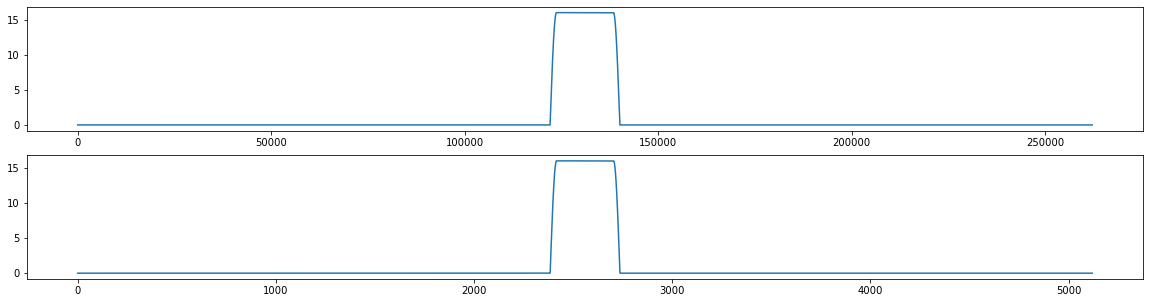

In [140]:
fig, axs = plt.subplots(2, 1, figsize=(20, 5))
# axs.plot(np.absolute(signal_nft[0]))
print(int(len(ft_filter_values[0])/ len(ft_filter_for_nft)))
print(len(ft_filter_for_nft))
axs[0].plot(range(0, len(ft_filter_values[0])), np.absolute(ft_filter_values[0].numpy()))
axs[1].plot(np.absolute(ft_filter_for_nft.numpy()))
print(len(signal_nft[0]))

[-1.00004170e-05+2.31192276e-06j -3.38133063e-06+3.12286966e-06j
 -4.32835930e-06+9.36633838e-06j ...  9.64238040e-06+4.20686676e-06j
 -4.30268627e-06+9.05280807e-06j  3.69234482e-06-2.80237271e-06j]
[-1.43996308e-06+1.05706614e-06j  1.19520920e-06+6.08823332e-07j
  3.58945187e-07+4.74329598e-07j ... -3.74102839e-07-4.53772140e-07j
  1.40181047e-06-1.11108398e-06j -4.43395703e-07+3.30854490e-07j]


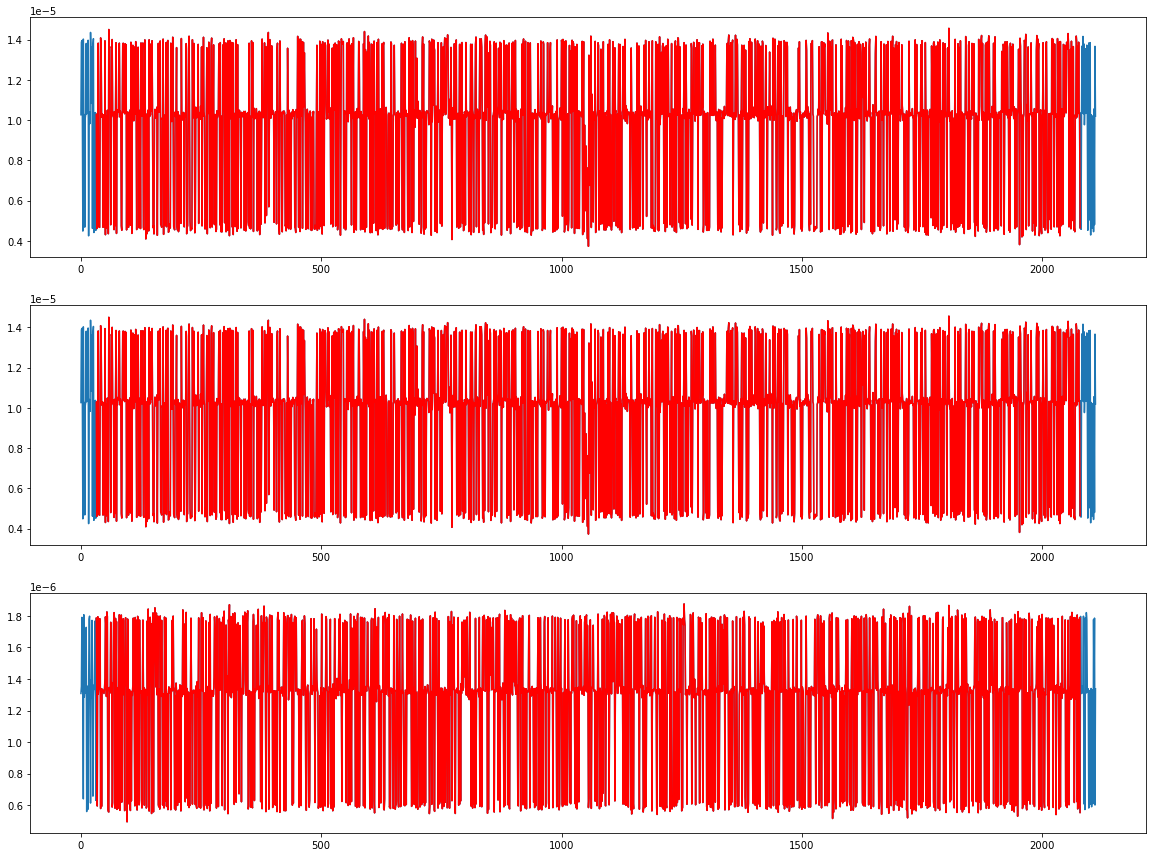

In [150]:
print(points_x_nft_proc[start_point:end_point])
print(points_x_cdc[start_point + process_parameters['n_symb_skip']:end_point + process_parameters['n_symb_skip']])

fig, axs = plt.subplots(3, 1, figsize=(20, 15))
# axs[0].plot(range(0, len(points_x_nft_proc)), np.absolute(ifftshift(points_x_nft_proc)))
# axs[0].plot(range(start_point, end_point), np.absolute(ifftshift(points_x_nft_proc)[start_point:end_point]), color='red')
#
# axs[1].plot(range(0, end_point + 10), np.absolute(ifftshift(points_x_nft_proc)[0:end_point+10]))
# axs[1].plot(range(start_point, end_point), np.absolute(ifftshift(points_x_nft_proc)[start_point:end_point]), color='red')

axs[0].plot(range(0, len(points_x_nft_proc)), np.absolute((points_x_nft_proc)))
axs[0].plot(range(start_point, end_point), np.absolute((points_x_nft_proc)[start_point:end_point]), color='red')

axs[1].plot(range(0, end_point + process_parameters['n_symb_side']), np.absolute((points_x_nft_proc)[0:end_point + process_parameters['n_symb_side']]))
axs[1].plot(range(start_point, end_point), np.absolute((points_x_nft_proc)[start_point:end_point]), color='red')

points_plot_range = points_x_cdc[start_point - process_parameters['n_symb_side'] + process_parameters['n_symb_skip']:
                                 end_point + process_parameters['n_symb_side'] + process_parameters['n_symb_skip']]
points_plot_range2 = points_x_cdc[start_point + process_parameters['n_symb_skip']:end_point + process_parameters['n_symb_skip']]
axs[2].plot(range(0, end_point + process_parameters['n_symb_side']), np.absolute(points_plot_range))
axs[2].plot(range(start_point, end_point), np.absolute(points_plot_range2), color='red')

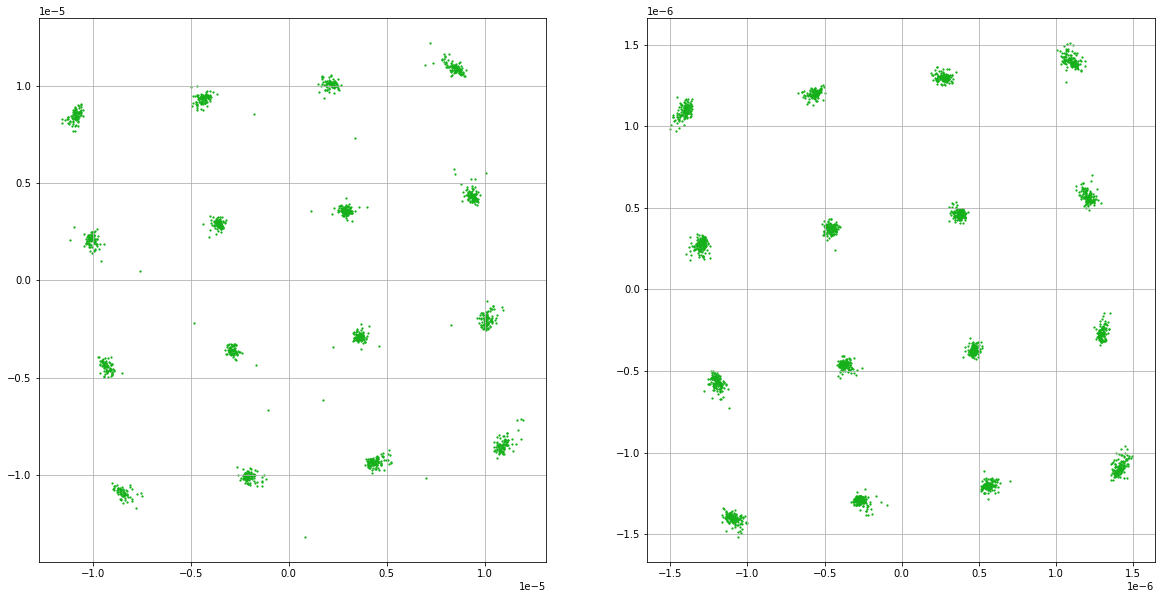

In [153]:
# point_to_plot = ifftshift(points_x_nft_proc)[start_point:end_point]
point_to_plot = points_x_nft_proc[start_point:end_point]

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# points_plot_range = fftshift(points_x_nft_proc)[start_point:end_point]
# axs[0].scatter(points_plot_range.real, points_plot_range.imag, s=6, c='xkcd:green', marker='.')
# axs[0].scatter(points_x_nft_proc.real, points_x_nft_proc.imag, s=6, c='xkcd:green', marker='.')
axs[0].scatter(point_to_plot.real, point_to_plot.imag, s=6, c='xkcd:green', marker='.')
# axs[0].scatter(points_x_cdc_shifted.real, points_x_cdc_shifted.imag, s=12, c='green', marker='x')
# axs[0].scatter(points_x_orig.real, points_x_orig.imag, s=20, c='xkcd:deep blue', marker='*')
axs[0].grid(True)

points_plot_range = points_x_cdc[start_point + process_parameters['n_symb_skip']:end_point + process_parameters['n_symb_skip']]
axs[1].scatter(points_plot_range.real, points_plot_range.imag, s=6, c='xkcd:green', marker='.')
# axs[1].scatter(points_y_cdc_shifted.real, points_y_cdc_shifted.imag, s=6, c='xkcd:green', marker='x')
# axs[1].scatter(points_y_orig.real, points_y_orig.imag, s=20, c='xkcd:deep blue', marker='*')
axs[1].grid(True)